In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import ROOT
import uproot
%jsroot on

Welcome to JupyROOT 6.28/04


In [2]:
# file_input_name = '../runs/calibration_4_photonCreator.root'
# file_input_name = '../runs/output_2.root'
file_input_name = '../build/calibration_0_0_0.root'
histogram_directory = 'photoSensor_hits_histograms'
file_input_pyroot = ROOT.TFile(file_input_name)
file_input_uproot = uproot.open(file_input_name)

histogram_names = file_input_uproot.keys()
histogram_names = [name for name in histogram_names if histogram_directory + '/photoSensor_' in name]
tree_names = file_input_uproot.keys()
tree_names = [name for name in tree_names if histogram_directory not in name]

print(histogram_names)
print(tree_names)

['photoSensor_hits_histograms/photoSensor_0;1', 'photoSensor_hits_histograms/photoSensor_1;1', 'photoSensor_hits_histograms/photoSensor_2;1', 'photoSensor_hits_histograms/photoSensor_3;1', 'photoSensor_hits_histograms/photoSensor_4;1', 'photoSensor_hits_histograms/photoSensor_5;1', 'photoSensor_hits_histograms/photoSensor_6;1', 'photoSensor_hits_histograms/photoSensor_7;1', 'photoSensor_hits_histograms/photoSensor_8;1', 'photoSensor_hits_histograms/photoSensor_9;1', 'photoSensor_hits_histograms/photoSensor_10;1', 'photoSensor_hits_histograms/photoSensor_11;1', 'photoSensor_hits_histograms/photoSensor_12;1', 'photoSensor_hits_histograms/photoSensor_13;1', 'photoSensor_hits_histograms/photoSensor_14;1', 'photoSensor_hits_histograms/photoSensor_15;1', 'photoSensor_hits_histograms/photoSensor_16;1', 'photoSensor_hits_histograms/photoSensor_17;1', 'photoSensor_hits_histograms/photoSensor_18;1', 'photoSensor_hits_histograms/photoSensor_19;1', 'photoSensor_hits_histograms/photoSensor_20;1', '

In [3]:
hits_list_library = {}
hits_hist_library = {}
for name in histogram_names:
    # Get the histogram from the ROOT file
    histogram = file_input_pyroot.Get(name)

    # Get the number of bins in the X and Y directions
    n_bins_x = histogram.GetNbinsX()
    n_bins_y = histogram.GetNbinsY()

    # Create NumPy arrays to store the bin contents and edges
    values = np.zeros((n_bins_x, n_bins_y))
    hits = []
    x_edges = []
    y_edges = []

    # Extract the bin contents (values) and edges
    for i in range(1, n_bins_x + 2):
        x_edges.append(histogram.GetXaxis().GetBinLowEdge(i))
    for i in range(1, n_bins_y + 2):
        y_edges.append(histogram.GetYaxis().GetBinLowEdge(i))

    for i in range(n_bins_x):  # Change the range to avoid going out of bounds
        for j in range(n_bins_y):  # Change the range to avoid going out of bounds
            values[i][j] = histogram.GetBinContent(j + 1, i + 1)
            if histogram.GetBinContent(j + 1, i + 1) > 0:
                # Check if edges are within bounds before accessing
                if j < len(y_edges) - 1 and i < len(x_edges) - 1:
                    hits.append(
                        (y_edges[j] + (y_edges[j + 1] - y_edges[j]) / 2, x_edges[i] + (x_edges[i + 1] - x_edges[i]) / 2)
                    )

    print(name,hits)
    hits_list_library[name] = hits
    hits_hist_library[name] = values

photoSensor_hits_histograms/photoSensor_0;1 []
photoSensor_hits_histograms/photoSensor_1;1 []
photoSensor_hits_histograms/photoSensor_2;1 []
photoSensor_hits_histograms/photoSensor_3;1 []
photoSensor_hits_histograms/photoSensor_4;1 []
photoSensor_hits_histograms/photoSensor_5;1 []
photoSensor_hits_histograms/photoSensor_6;1 []
photoSensor_hits_histograms/photoSensor_7;1 []
photoSensor_hits_histograms/photoSensor_8;1 []
photoSensor_hits_histograms/photoSensor_9;1 []
photoSensor_hits_histograms/photoSensor_10;1 []
photoSensor_hits_histograms/photoSensor_11;1 []
photoSensor_hits_histograms/photoSensor_12;1 []
photoSensor_hits_histograms/photoSensor_13;1 [(11.5, -0.5)]
photoSensor_hits_histograms/photoSensor_14;1 []
photoSensor_hits_histograms/photoSensor_15;1 []
photoSensor_hits_histograms/photoSensor_16;1 []
photoSensor_hits_histograms/photoSensor_17;1 []
photoSensor_hits_histograms/photoSensor_18;1 []
photoSensor_hits_histograms/photoSensor_19;1 []
photoSensor_hits_histograms/photoSenso

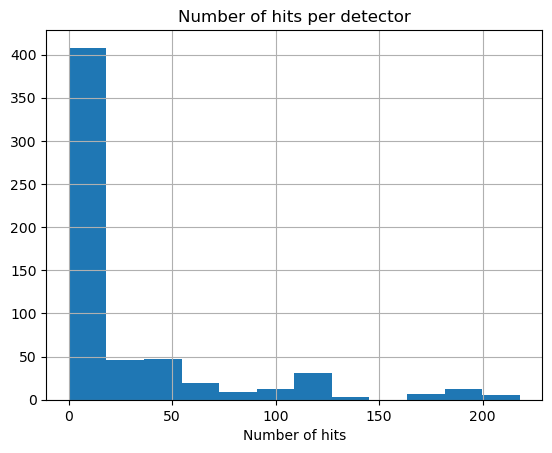

In [4]:
# Find the entry in hits_library with the largest length
# make a list of the index and length
lengths = [(i, len(hits)) for i, hits in enumerate(hits_list_library.values())]
lengths.sort(key=lambda x: x[1])

plt.hist([lengths[i][1] for i in range(len(lengths))], bins=12)
plt.xlabel("Number of hits")
plt.ylabel("")
plt.title("Number of hits per detector")
plt.grid()
plt.show()

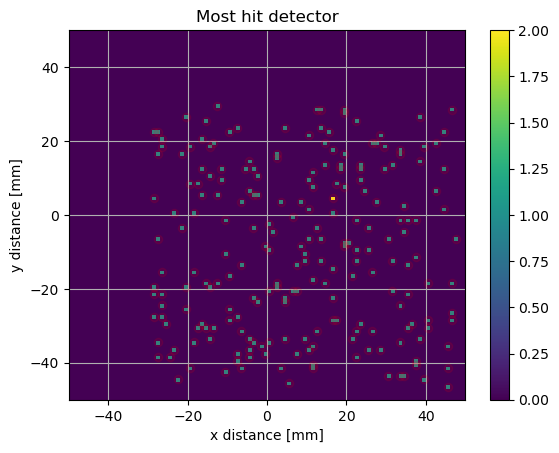

In [5]:
index, length = lengths[-1]
hits = list(hits_list_library.values())[index]
values = list(hits_hist_library.values())[index]

plt.imshow(values, extent=(x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]), aspect='auto', origin='lower', cmap='viridis')
plt.plot([x[0] for x in hits], [x[1] for x in hits], 'o', alpha=0.1, color='red')
plt.colorbar()
plt.xlabel("x distance [mm]")
plt.ylabel("y distance [mm]")
plt.title("Most hit detector")
plt.grid()
plt.show()

In [6]:
# Load the trees from the root file
tree_library = {}
tree_branch_library = {}
branch_data = {}
for name in tree_names:
    tree_library[name] = file_input_uproot[name]
    tree_branch_library[name] = tree_library[name].keys()
    for key in tree_branch_library[name]:
        branch_data[key] = tree_library[name][key].array()

In [7]:
# %matplotlib qt

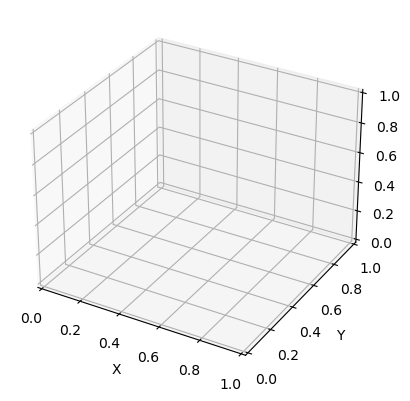

In [8]:
primary_position_x  = np.array(branch_data['primary_position_x'])
primary_position_y  = np.array(branch_data['primary_position_y'])
primary_position_z  = np.array(branch_data['primary_position_z'])
primary_direction_x = np.array(branch_data['primary_direction_x'])
primary_direction_y = np.array(branch_data['primary_direction_y'])
primary_direction_z = np.array(branch_data['primary_direction_z'])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(primary_position_x , primary_position_y , primary_position_z , 
          primary_direction_x, primary_direction_y, primary_direction_z, 
          length=0.1, color='red')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [9]:
%matplotlib inline

In [10]:
# Extract the data for photon_process and photon_volume
photon_process = branch_data['photon_process']
photon_volume = branch_data['photon_volume']

# Make a list of the unique photon_process and photon_volume values
unique_photon_process = np.unique(photon_process)
unique_photon_volume = np.unique(photon_volume)

# Make a dictionary to store the number of photons in each process and volume
photon_process_count = {}
photon_volume_count = {}

# Loop over the unique photon_process values
for process in unique_photon_process:
    # Get the indices for the current process
    indices = np.where(photon_process == process)
    # Store the number of photons in the current process
    photon_process_count[process] = len(indices[0])

# Loop over the unique photon_volume values
for volume in unique_photon_volume:
    # Get the indices for the current volume
    indices = np.where(photon_volume == volume)
    # Store the number of photons in the current volume
    photon_volume_count[volume] = len(indices[0])

# Print the photon_process_count and photon_volume_count dictionaries
print(photon_process_count)
print(photon_volume_count)

# Combine individualy named volumes into more general volumes
photon_volume_general_count = {}
for volume in photon_volume_count:
    if 'lensSystem_solid' in volume:
        photon_volume_general_count['lensSystem_solid'] = photon_volume_general_count.get('lensSystem_solid', 0) + photon_volume_count[volume]
    elif 'photoSensor_surface' in volume:
        photon_volume_general_count['photoSensor_surface'] = photon_volume_general_count.get('photoSensor_surface', 0) + photon_volume_count[volume]
    elif 'photoSensor_body' in volume:
        photon_volume_general_count['phototSensor_body'] = photon_volume_general_count.get('phototSensor_body', 0) + photon_volume_count[volume]
    elif 'calorimeter_horizontal' in volume:
        photon_volume_general_count['calorimeter_horizontal'] = photon_volume_general_count.get('calorimeter_horizontal', 0) + photon_volume_count[volume]
    elif 'calorimeter_vertical' in volume:
        photon_volume_general_count['calorimeter_vertical'] = photon_volume_general_count.get('calorimeter_vertical', 0) + photon_volume_count[volume]
    elif 'calorimeter_middle' in volume:
        photon_volume_general_count['calorimeter_middle'] = photon_volume_general_count.get('calorimeter_middle', 0) + photon_volume_count[volume]
    else:
        photon_volume_general_count[volume] = photon_volume_general_count.get(volume, 0) + photon_volume_count[volume]

# Print the photon_volume_general_count dictionary
print(photon_volume_general_count)

{'OpAbsorption': 893590, 'OpRayleigh': 1875, 'Transportation': 307174}
{'/DSPD_+x_0_lensSystem_solid': 15, '/DSPD_+x_10_lensSystem_solid': 22, '/DSPD_+x_11_lensSystem_solid': 37, '/DSPD_+x_12_lensSystem_solid': 67, '/DSPD_+x_13_lensSystem_solid': 88, '/DSPD_+x_13_photoSensor_body': 1, '/DSPD_+x_13_photoSensor_surface': 1, '/DSPD_+x_14_lensSystem_solid': 158, '/DSPD_+x_15_lensSystem_solid': 114, '/DSPD_+x_16_lensSystem_solid': 114, '/DSPD_+x_16_photoSensor_surface': 1, '/DSPD_+x_17_lensSystem_solid': 90, '/DSPD_+x_18_lensSystem_solid': 32, '/DSPD_+x_19_lensSystem_solid': 20, '/DSPD_+x_1_lensSystem_solid': 29, '/DSPD_+x_20_lensSystem_solid': 46, '/DSPD_+x_21_lensSystem_solid': 72, '/DSPD_+x_21_photoSensor_body': 1, '/DSPD_+x_22_lensSystem_solid': 104, '/DSPD_+x_22_photoSensor_body': 15, '/DSPD_+x_22_photoSensor_surface': 15, '/DSPD_+x_23_lensSystem_solid': 190, '/DSPD_+x_23_photoSensor_body': 25, '/DSPD_+x_23_photoSensor_surface': 30, '/DSPD_+x_24_lensSystem_solid': 287, '/DSPD_+x_24_pho

[83411, 15866, 16352, 45235, 3545, 45151, 964464, 14159, 14456]
[893590, 1875, 307174]


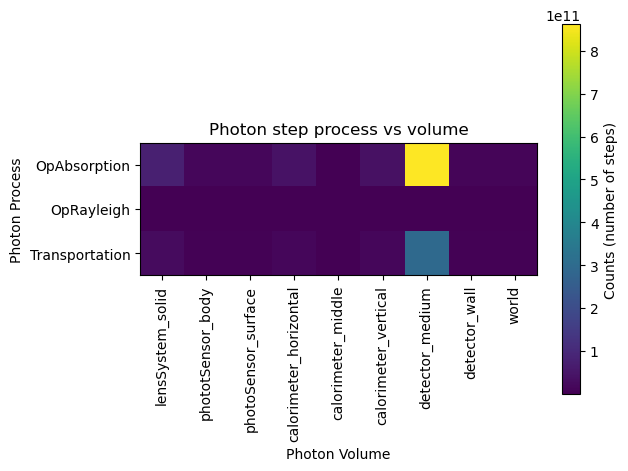

In [11]:
photon_volume_general_count_values = list(photon_volume_general_count.values())
photon_process_count_values = list(photon_process_count.values())

print(photon_volume_general_count_values)
print(photon_process_count_values)

convolution_matrix = np.outer(photon_process_count_values, photon_volume_general_count_values)
plt.imshow(convolution_matrix, cmap='viridis')
plt.xlabel("Photon Volume")
plt.ylabel("Photon Process")
plt.title("Photon step process vs volume")
plt.yticks(range(len(photon_process_count)), photon_process_count.keys())
plt.xticks(range(len(photon_volume_general_count)), photon_volume_general_count.keys())
plt.xticks(rotation=90)
plt.colorbar(label='Counts (number of steps)')
plt.show()